In [24]:
import os
import glob
import random
import numpy as np

In [8]:
ROOT = os.path.join(os.getcwd(),'img')
img_folders = {
    'clown':os.path.join(ROOT,'clown'),
    'reef':os.path.join(ROOT,'reef')
}

In [9]:
RESULT = {
    0:'Clown Fish',
    1:'No clown fish'
}

# All in one loading and preprocessing

In [10]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [11]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]


train_transforms = transforms.Compose([transforms.Resize(size=224),
                                       transforms.CenterCrop(size=224),
                                       transforms.ToTensor(),
                                       ])

# change root to valid dir in your system, see ImageFolder documentation for more info
dataset = datasets.ImageFolder(root=ROOT,
                                    transform=train_transforms)

In [12]:
N = round(len(dataset)*0.7)
indices = list(range(len(dataset)))
train_ids = np.random.choice(indices,size=N,replace=False)
test_ids = list(set(indices) - set(train_ids))

In [13]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_ids)
test_sampler = SubsetRandomSampler(test_ids)

In [14]:
trainset = DataLoader(dataset=dataset,
                      batch_size=8,
                      #shuffle=True,
                      sampler = train_sampler
                      #collate_fn=my_collate # use custom collate function here
                      )
testset = DataLoader(dataset=dataset,
                      batch_size=2,
                        #shuffle=True,
                      sampler = test_sampler
                      )

trainiter = iter(trainset)
imgs, labels = trainiter.next()

Clown Fish


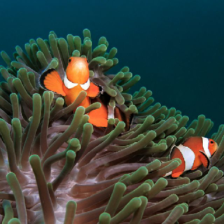

In [15]:
example = imgs[0]
print(RESULT[labels[0].item()])
transforms.ToPILImage()(example)

# Training part

# Define network

In [16]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [17]:
def abs_size(x):
    S = x.size()
    result = 1
    for s in S[1:]:
        result *= s
    return result

In [18]:
class FishNet(nn.Module):
    def __init__(self,number_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.apool = nn.AdaptiveAvgPool2d(16)
        self.fc1 = nn.Linear(16 * 16 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.apool(x)
        x = x.view(-1, abs_size(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


mynet = FishNet(2)
mynet

FishNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (apool): AdaptiveAvgPool2d(output_size=16)
  (fc1): Linear(in_features=4096, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

## Optimizer

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.001, momentum=0.9)

LOSSES = []

In [20]:
def adjust_learning_rate(optimizer, decay_factor=0.1):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_factor
        
    return optimizer

In [21]:
def is_stagnant(L,n=10,eps=1e-2):
    M1 = np.mean(L[-2*n:-n])
    M2 = np.mean(L[-n:])
    D = (M1-M2)/(M1+M2)
    return abs(D)<eps

In [72]:
# TO DO
#optim.lr_scheduler.

## Train step

In [23]:
print_batch = 10
N_epoch = 50

for epoch in range(1,N_epoch+1):  # loop over the dataset multiple times
    
    print('---------- Epoch {:03d} ----------'.format(epoch))
    running_loss = 0.0
    
    for i, data in enumerate(trainset, 1):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mynet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() #loss.data[0] deprecated in newer versions of PyTorch
        if i % print_batch == 0:    # print every few mini-batches
            LOSSES.append(running_loss)
            print('     Batch {:02d} | Loss: {:.4f}'.format(i ,running_loss / print_batch))
            running_loss = 0.0
            
    # Decay LR when learning is stalling, for better convergence
    if epoch>6 and is_stagnant(LOSSES,3):
        optimizer = adjust_learning_rate(optimizer)
        print('\n','='*10,'LR decayed by 10','='*10,'\n')
            
print('Finished Training')

---------- Epoch 001 ----------
     Batch 10 | Loss: 0.4942
     Batch 20 | Loss: 0.6792
     Batch 30 | Loss: 0.3466
---------- Epoch 002 ----------
     Batch 10 | Loss: 0.2839
     Batch 20 | Loss: 0.3149
     Batch 30 | Loss: 0.1765
---------- Epoch 003 ----------
     Batch 10 | Loss: 0.2000
     Batch 20 | Loss: 0.1714
     Batch 30 | Loss: 0.1542
---------- Epoch 004 ----------
     Batch 10 | Loss: 0.1356
     Batch 20 | Loss: 0.1465
     Batch 30 | Loss: 0.1082
---------- Epoch 005 ----------
     Batch 10 | Loss: 0.1769
     Batch 20 | Loss: 0.1370
     Batch 30 | Loss: 0.1151
---------- Epoch 006 ----------
     Batch 10 | Loss: 0.0614
     Batch 20 | Loss: 0.0969
     Batch 30 | Loss: 0.1000
---------- Epoch 007 ----------
     Batch 10 | Loss: 0.2086
     Batch 20 | Loss: 0.1378
     Batch 30 | Loss: 0.1233
---------- Epoch 008 ----------
     Batch 10 | Loss: 0.0866
     Batch 20 | Loss: 0.1286
     Batch 30 | Loss: 0.0856
---------- Epoch 009 ----------
     Batch 10 | 

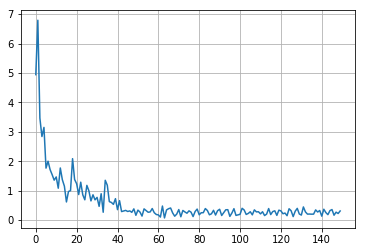

In [25]:
import matplotlib.pyplot as plt

plt.plot(LOSSES)
plt.grid()
plt.show()

## Save model

In [26]:
import datetime
now = datetime.datetime.now().strftime('%Y%m%d_%Hh%M')
now

'20180709_08h16'

In [27]:
torch.save(mynet.state_dict,'FishNet_'+now+'.pth')
#torch.save(mynet,'FishNet_'+now+'.pth')

/anaconda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FishNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Load model

In [5]:
models_path = glob.glob('*.pth')
models_path.sort()
models_path

['FishNet_20180705_21h41.pth',
 'FishNet_20180705_22h31.pth',
 'FishNet_20180706_07h25.pth',
 'FishNet_20180706_07h36.pth']

In [22]:
mynet.load_state_dict(torch.load(models_path[-1])())
mynet.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0215,  0.0772, -0.0985, -0.0383, -0.0315],
                        [ 0.1218, -0.0666, -0.0194, -0.0782, -0.0474],
                        [ 0.0643,  0.0253, -0.0469, -0.0021,  0.0526],
                        [ 0.0047, -0.0508, -0.0555, -0.0713, -0.0641],
                        [-0.0174,  0.0871,  0.0539, -0.0995,  0.0844]],
              
                       [[ 0.0302,  0.0520, -0.0208,  0.1549,  0.0947],
                        [ 0.0273, -0.0123,  0.1304, -0.0054,  0.1084],
                        [ 0.0073, -0.0428,  0.0328, -0.0250,  0.1260],
                        [-0.0319, -0.0709,  0.1324, -0.0299,  0.0713],
                        [-0.0260, -0.0797,  0.0361,  0.0397, -0.0605]],
              
                       [[ 0.0984,  0.1476,  0.1132,  0.0394,  0.0014],
                        [ 0.0662,  0.1706,  0.1233,  0.0587, -0.0460],
                        [ 0.1118,  0.0062,  0.1662,  0.1232,  0.0380],
               

## Test step

In [34]:
errors = 0
mynet.eval()

for i, data in enumerate(testset):
    inputs, labels = data
    inputs, labels = Variable(inputs), Variable(labels)
    outputs = mynet(inputs)
    _,y = torch.max(outputs,1)
    errors += (y!=labels).sum().item()
    
accuracy = 1-errors/len(testset)
print('{:0.2f}% accuracy on the test set'.format(100*accuracy))

75.81% accuracy on the test set


Clown Fish


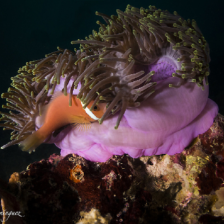

In [35]:
print(RESULT[y[0].item()])
transforms.ToPILImage()(inputs[0].data)